# Data Cleaning & Pre-Processing

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cleaning_functions as cf
from unidecode import unidecode # source: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string 

In [2]:
# Source (via Wine.com) : https://www.kaggle.com/datasets/salohiddindev/wine-dataset-scraping-from-wine-com (prices in USD)
df_wine_com = pd.read_csv("../data/original_datasets/wine_com.csv", encoding='utf-16')

# Source (via Vivino.com): https://www.kaggle.com/datasets/budnyak/wine-rating-and-price (prices in EUR)
df_viv_1 = pd.read_csv('../data/original_datasets/vivino_one.csv')
df_viv_1.drop(columns=['Unnamed: 0'], inplace=True)

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_viv_2 = pd.read_csv('../data/original_datasets/vivino_two.csv')

# Source (via Vivino.com): https://www.kaggle.com/datasets/nikitatkachenko/vivinoredwine/data (prices in USD)
df_viv_3 = pd.read_csv('../data/original_datasets/validation_set.csv',encoding='latin1')
df_viv_3.dropna(inplace=True)
df_viv_3.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
# Make column names snake_case.
df_viv_1.columns = [col.lower().replace(' ', '_') for col in df_viv_1.columns]
df_viv_2.columns = [col.lower().replace(' ', '_') for col in df_viv_2.columns]
df_wine_com.columns = [col.lower().replace(' %', '').replace(' ', '_') for col in df_wine_com.columns]
df_viv_3.columns = [col.lower().replace(' ', '_') for col in df_viv_3.columns]

# Cleaning wine.com Dataset

In [4]:
df_wine_com.head()

,names,color_wine,prices,ml,ratings,ratingsnum,countrys,abv,rates
0,00 Wines VGW Chardonnay 2017,White Wine,79.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS"
1,00 Wines VGR Pinot Noir 2019,Red Wine,99.99$,750,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP"
2,00 Wines EGW Chardonnay 2019,White Wine,115.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE"
3,100 Nails Ranch Pinot Noir 2019,Red Wine,16.99$,750,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW
4,100 Nails Ranch Chardonnay 2019,White Wine,16.99$,750,0.0,0,"Chardonnay from Sonoma County, California",14.2,0


In [5]:
df_wine_com.shape

(15254, 9)

In [6]:
df_wine_com.drop_duplicates(inplace=True)

In [7]:
# Correct prices 
df_wine_com['prices'] = df_wine_com['prices'].str.replace(',', '').str.replace('$', '').astype(float)

In [8]:
# Extract column for vintage from name column
df_wine_com['vintage'] = df_wine_com['names'].apply(cf.get_vintage)
df_wine_com['vintage'].value_counts().head()

vintage
2019    3050
2020    2873
2018    2317
2021    1788
2017    1373
Name: count, dtype: int64

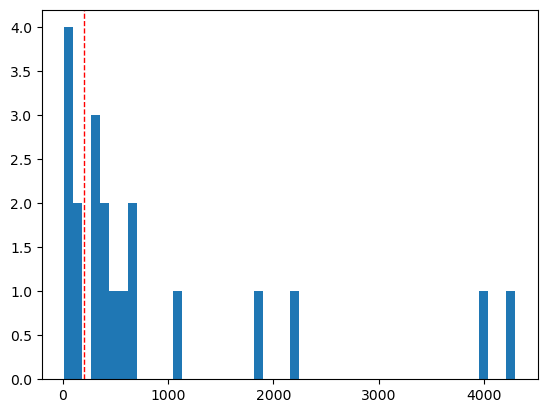

In [9]:
# Investigate very old wines
old_wines = df_wine_com[df_wine_com['vintage'] < '1985']
plt.hist(old_wines['prices'], bins=50)
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=1, label='$200');

In [10]:
'''
Remove vintage for wines below $200 in price and 'older' than 1985, having investgated them 
individually these are wines with the established year of the producer in their name 
not the year grape was picked.
'''
df_wine_com.loc[(df_wine_com['prices'] < 200) & (df_wine_com['vintage'] < '1985'), 'vintage'] = 'unknown'

In [11]:
# Keep only 750ml bottles.
df_wine_com = df_wine_com[df_wine_com['ml'] == 750].copy()
df_wine_com.drop(columns=['ml'], inplace=True)

In [12]:
df_wine_com['color_wine'].value_counts()

color_wine
Red Wine                 8983
White Wine               3687
Sparkling & Champagne     959
Pink and Rosé             413
0                         199
Collectible                25
Screw Cap                  20
Boutique                    7
Green Wine                  4
Great Gift                  2
Name: count, dtype: int64

In [13]:
df_wine_com['color_wine'] = df_wine_com['color_wine'].apply(cf.remove_accents)
df_wine_com['wine_variety'] = df_wine_com['color_wine'].apply(cf.get_wine_variety)
df_wine_com.drop(columns=['color_wine'], inplace=True)
df_wine_com['wine_variety'].value_counts()

wine_variety
red          8983
white        3687
sparkling     959
rose          413
other         257
Name: count, dtype: int64

In [14]:
# Remove 'other' wine varieties
df_wine_com = df_wine_com[df_wine_com['wine_variety'] != 'unknown'].copy()

In [15]:
# Rename columns 
df_wine_com.rename(columns = {'names' : 'name',
                            'prices' : 'price',
                            'ratings' : 'rating',
                            'ratingsnum': 'rating_qty', 
                            'rates' : 'reviewed_by'}, inplace = True)

In [16]:
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [17]:
df_wine_com['region'] = df_wine_com['countrys'].apply(cf.get_region)
# Drop 33 wines where region was not found 
df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()

In [18]:
# Extract country name from country column 
df_wine_com['country'] = df_wine_com['countrys'].apply(cf.get_country)
df_wine_com['country'].value_counts()

country
France          4128
California      2845
Italy           2381
unknown         1363
Spain            926
Australia        433
Argentina        407
Washington       300
Germany          258
Oregon           241
Portugal         219
Chile            219
New Zealand      202
Other U.S.       107
South Africa      99
Austria           74
Greece            62
Canada             2
Name: count, dtype: int64

In [19]:
# Investigate the unknown countries 
df_wine_com[df_wine_com['country'] == 'unknown']

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country
6,1000 Stories Bourbon Barrel Aged Prospectors P...,19.99,0.0,0,Cabernet Sauvignon from California,0.0,WW,2020,red,California,unknown
7,1000 Stories American Barrel Aged Pinot Noir 2020,17.99,0.0,0,Pinot Noir from California,14.5,0,2020,red,California,unknown
8,1000 Stories Bourbon Barrel Aged Zinfandel 2020,18.99,3.8,11,Zinfandel from California,15.5,WW,2020,red,California,unknown
9,1000 Stories Bourbon Barrel Aged Chardonnay 2019,19.99,4.4,10,Chardonnay from California,14.4,TP,2019,white,California,unknown
10,1000 Stories Bourbon Barrel Aged Prospectors P...,18.99,0.0,0,Cabernet Sauvignon from California,14.9,0,2018,red,California,unknown
...,...,...,...,...,...,...,...,...,...,...,...
15210,Vinos Atlantico Vera Vinho Verde Rose 2021,12.99,0.0,0,Rosé from Portugal,11.5,0,2021,rose,Portugal,unknown
15212,Vinos De Arganza Marques De Montejos Mencia 2020,13.99,0.0,0,Mencia from Spain,13.0,"JS, WW",2020,red,Spain,unknown
15214,Vinos De Arganza Alvarez De Toledo Godello 2021,11.99,4.8,29,Godello from Spain,0.0,WW,2021,white,Spain,unknown
15215,Vinos De Arganza Palacio De Arganza Cabernet S...,13.99,4.8,30,Other Red Blends from Spain,13.0,"JS, WW",2020,red,Spain,unknown


In [20]:
df_wine_com.loc[df_wine_com['region'].isin(cf.us_states), 'country'] = 'United States'

In [21]:
# All unknown countries are cases where no region was available. The country was populated in the region or a US state. 
region_problems = df_wine_com[df_wine_com['country'] == 'unknown']
region_problems['region'].value_counts()

region
Israel               115
South Africa         105
Chile                 70
Portugal              70
Spain                 69
France                60
Italy                 55
Argentina             32
Austria               23
Uruguay               23
Greece                23
Australia             20
Lebanon               11
England               10
Slovenia               9
Germany                9
Hungary                8
Croatia                6
Brazil                 5
Armenia                3
New Zealand            3
China                  2
Other                  2
Macedonia (FYROM)      2
Other U.S.             1
Name: count, dtype: int64

In [22]:
# move those regions that are countries to the country column 
df_wine_com.loc[df_wine_com['country'] == 'unknown', 'country'] = df_wine_com.loc[df_wine_com['country'] == 'unknown', 'region']
# make those regions that are countries 'unknown'
df_wine_com.loc[df_wine_com['region'] == df_wine_com['country'], 'region'] = 'unknown'
# combine U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'Other U.S.', 'country'] = 'United States'
# combine all U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'California', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Washington', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Oregon', 'country'] = 'United States'
# rename macedonia 
df_wine_com.loc[df_wine_com['country'] == 'Macedonia (FYROM)', 'country'] = 'Macedonia'

df_wine_com['country'].value_counts()

country
France           4188
United States    4121
Italy            2436
Spain             995
Australia         453
Argentina         439
Chile             289
Portugal          289
Germany           267
New Zealand       205
South Africa      204
Israel            115
Austria            97
Greece             85
Uruguay            23
Lebanon            11
England            10
Slovenia            9
Hungary             8
Croatia             6
Brazil              5
Armenia             3
China               2
Other               2
Canada              2
Macedonia           2
Name: count, dtype: int64

In [23]:
df_wine_com['grape_variety'] = df_wine_com['countrys'].apply(cf.get_grape_1)

In [24]:
# EXTRACT PRODUCER NAMES 
# Step 1 - Match with producers from other datasets and custom list in cleaning_functions.py 
all_producers = list(df_viv_1['winery'].unique()) + list(df_viv_2['winery'].unique()) + list(df_viv_3['winery'].unique()) + cf.custom_producer_list
all_producers  = [cf.uniform_strings(word) for word in all_producers]
all_producers.remove('Domaine De La')

In [25]:
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [26]:
# 80% of producers matched by finding producer names from other datasets and custom list in cleaning_functions.py
# 2741 producers matched of total 14266
df_wine_com['producer_clean'] = df_wine_com['name'].apply(lambda x: cf.extract_string(x, all_producers))

In [27]:
check_wine = df_wine_com[df_wine_com['producer_clean'] == 'review']
check_wine.shape
df_wine_com['producer_clean'].value_counts().head()

producer_clean
review          2741
Louis Latour      80
Sine Qua Non      55
Chanson           35
Guigal            33
Name: count, dtype: int64

In [28]:
# test = 'Wine De LA Abbona'
# test1 = "Wine De LA Annabella"
# test2 = '1849 wine wine'
# test3 = 'Aj Adam D Hofberg'
# test4 = 'Ydooker Gigglepot'
# test5 = 'Mollydooker Blue Eyed Boy Shiraz 2020'
# test6 = 'Reira Dona Antonia 10 Year Tawny Port'
# test7 = 'Tamarack Cellars Firehouse Red 2019'
# test8 = 'Domaine De La Charbonniere Chateauneufdupape Mourre Des Perdrix 2016'
# extract_string(test8, all_producers)

In [29]:
# STEP 2 - Isolate part before grape names in column 'name' import list of grape varieties.
# This removes grape and year from X leaving X for review. X producers remain that have not be captured by first 2 steps. 
grape_list_long = pd.read_csv('../data/grape_varieties.csv')
grape_list_long.drop(columns = ['Unnamed: 0'], inplace = True)
varietal_set_long = set(grape_list_long['Variety'].dropna().apply(lambda x: cf.uniform_strings(x).strip().lower()))

In [30]:
# test = 'Chardonnay Vinny  oz Mc Vinard Malbec  2002'
# test1 = 'Vinny Mc Vinard Malbec Chardonnay Cats 2002'
# test2 = 'Vinny Mc Vinard don Don 2002'
# test3 = 'Vinny Mc Vinard Pinot Noir 2002'
# test4 = 'Chardon Don Vineyard Chardonnay 2020'
# test5 = 'Aj Adam Hofberg Reserve Riesling Trocken 2019' # ISSUE HERE WITH {GRAPE}{OTHER-STRING}{YEAR}
# test6 = 'Aj Adam Hofberg Reserve Riesling 2020'

# cf.remove_varietal(test6, varietal_set_long)

In [31]:
df_wine_com['producer_varietal_removed'] = df_wine_com['name'].apply(lambda x : cf.remove_varietal(x, varietal_set_long))

In [32]:
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review')]

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed
13,12 Linajes Crianza 2014,31.99,3.9,17,"Tempranillo from Ribera del Duero, Spain",14.5,WE,2014,red,Ribera del Duero,Spain,Tempranillo,12 Linajes,review
35,19 Crimes The Warden 2018,20.99,3.7,12,"Syrah/Shiraz from South East Australia, Australia",0.0,0,2018,red,South East Australia,Australia,Syrah/Shiraz,19 Crimes,review
36,19 Crimes Hard Chard 2021,20.99,3.0,13,Chardonnay from Australia,14.0,0,2021,white,unknown,Australia,Chardonnay,19 Crimes,review
37,19 Crimes Marthas Chard 2020,13.99,3.8,24,Chardonnay from California,13.8,0,2020,white,California,United States,Chardonnay,19 Crimes,review
38,19 Crimes The Uprising 2020,11.99,4.1,41,Other Red Blends from Australia,0.0,0,2020,red,unknown,Australia,Other Red Blends,19 Crimes,review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15242,Viticcio Chianti Classico 2018,21.99,0.0,0,"Sangiovese from Chianti Classico, Chianti, Tus...",14.0,0,2018,red,Chianti Classico,Italy,Sangiovese,Viticcio,review
15244,Vivaltus 2016,99.99,0.0,0,"Tempranillo from Ribera del Duero, Spain",0.0,"D, RP",2016,red,Ribera del Duero,Spain,Tempranillo,Vivaltus,review
15246,Vivaltus La Fleur Vivaltus 2016,46.99,0.0,0,"Tempranillo from Ribera del Duero, Spain",14.5,RP,2016,red,Ribera del Duero,Spain,Tempranillo,Vivaltus,review
15247,Vivanco Rioja Blanco 2019,14.99,3.8,6,"Other White Blends from Rioja, Spain",13.0,0,2019,white,Rioja,Spain,Other White Blends,Vivanco,review


In [33]:
df_wine_com.loc[df_wine_com['abv'] == 0, 'abv'] = np.nan

In [34]:
#2047 producers remain that have not be captured by first 2 steps. 
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review') & (df_wine_com['producer_clean'] == 'review')].shape

(1431, 14)

In [35]:
df_wine_com['producer_dirty'] = df_wine_com['name'].apply(cf.get_dirty_producer)

In [36]:
# # Done iteratively to add to custom producer list in cleaning_functions
# for i in np.sort(df_wine_com['producer_dirty'].unique()):
#     print(i)

In [37]:
# # Check --> (6405,)
# df_wine_com['producer_dirty'].unique().shape

In [38]:
shorterned_df = df_wine_com[(df_wine_com['producer_clean'] == 'review') &(df_wine_com['producer_varietal_removed'] == 'review')]

In [39]:
all_remaining_producers =  shorterned_df['producer_dirty'].value_counts().index
all_remaining_producers = all_remaining_producers.sort_values()

In [40]:
# No minimum number of ratings set for this scrape. 
df_wine_com['rating_qty'].describe()

count    14266.000000
mean        10.439577
std         49.378628
min          0.000000
25%          0.000000
50%          0.000000
75%          6.000000
max       1829.000000
Name: rating_qty, dtype: float64

In [41]:
df_wine_com['combined_methods_producer'] = df_wine_com.apply(cf.combine_methods, axis = 1)

In [42]:
df_wine_com['combined_methods_producer'].value_counts()

combined_methods_producer
Louis Latour       80
Sine Qua Non       55
Chanson            35
Guigal             33
Louis Jadot        33
                   ..
Abbott Claim        1
Fina                1
Vina Callejuela     1
Vina Ijalba         1
Vinas Del Cenit     1
Name: count, Length: 4432, dtype: int64

In [43]:
df_wine_com['producer'] = df_wine_com['combined_methods_producer']

In [44]:
# Investgate wine of price 9999.99
df_wine_com[df_wine_com['price'] == 9999.99]
# This is a collectable highly prized wine producer Chateau Petrus, explaining the high price

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed,producer_dirty,combined_methods_producer,producer
3810,Chateau Petrus 2016,9999.99,4.7,11,"Bordeaux Red Blends from Pomerol, Bordeaux, Fr...",14.5,"JS, RP, D, JD, WE, WS",2016,red,Pomerol,France,Bordeaux Red Blends,Petrus,review,Chateau Petrus,Petrus,Petrus


In [45]:
# Convert price to GBP £ using https://www.xe.com/currencytables/ at exchange rate date of scrape. 
df_wine_com['price'] = round((df_wine_com['price'] * 0.8214659183132513),2)

In [46]:
df_wine_com['from_vivino'] = False
df_wine_com.drop(columns=['producer_clean', 'producer_varietal_removed',
                            'producer_dirty', 'combined_methods_producer','countrys' ], inplace=True)

# Cleaning Vivino 1 Dataset

In [47]:
df_viv_1.drop_duplicates(inplace=True)
df_viv_1.head()


,name,country,region,winery,rating,numberofratings,price,year,category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,red
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,red
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,red
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,red
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,red


In [48]:
df_viv_1.shape

(34664, 9)

In [49]:
df_viv_1.rename(columns = {'winery' : 'producer', 
                           'numberofratings' : 'rating_qty', 
                           'category' : 'wine_variety',
                           'year' : 'vintage'
                           }, inplace = True)

In [50]:
# Remove accents from columns.
df_viv_1['name'] = df_viv_1['name'].apply(cf.uniform_strings)
df_viv_1['producer'] = df_viv_1['producer'].apply(cf.uniform_strings)
df_viv_1['region'] = df_viv_1['region'].apply(cf.uniform_strings)
df_viv_1['country'] = df_viv_1['country'].apply(cf.uniform_strings)

In [51]:
df_viv_1.loc[df_viv_1['producer'] == 'Domaine De La', 'producer'] = 'Domaine De La Rouge'

In [52]:
df_viv_1.dtypes

name             object
country          object
region           object
producer         object
rating          float64
rating_qty        int64
price           float64
vintage          object
wine_variety     object
dtype: object

In [53]:
# Make name formatting structure the same as wine_com dataframe.
df_viv_1['name'] = df_viv_1['producer'] + ' ' + df_viv_1['name']

In [54]:
df_viv_1['region'].value_counts()

region
Rioja                        1300
Toscana                       996
Stellenbosch                  928
Saintemilion Grand Cru        828
Barolo                        700
                             ... 
San Severo                      4
Barco Reale Di Carmignano       4
Southeastern Anatolia           4
Heathcote                       4
San Antonio Valley              4
Name: count, Length: 624, dtype: int64

In [55]:
df_viv_1['country'].value_counts()

country
Italy            10600
France            9024
Spain             4568
South Africa      2000
United States     1496
Chile             1304
Germany            992
Australia          984
Argentina          984
Portugal           920
Austria            880
New Zealand        252
Brazil             160
Romania             92
Lebanon             60
Israel              52
Greece              52
Switzerland         48
Hungary             36
Slovenia            32
Moldova             32
Turkey              24
Georgia             20
Uruguay             16
Canada               8
Croatia              8
Bulgaria             8
Mexico               4
Slovakia             4
China                4
Name: count, dtype: int64

In [56]:
df_viv_1.loc[df_viv_1['vintage'] == 'N.V.', 'vintage'] = np.nan

In [57]:
df_viv_1['rating'].describe()

count    34664.000000
mean         3.890342
std          0.308534
min          2.500000
25%          3.700000
50%          3.900000
75%          4.100000
max          4.800000
Name: rating, dtype: float64

In [58]:
# Minimum number of ratings 25 for this scrape. 
df_viv_1['rating_qty'].describe()

count    34664.000000
mean       415.287445
std        899.687438
min         25.000000
25%         66.000000
50%        157.000000
75%        401.000000
max      20293.000000
Name: rating_qty, dtype: float64

In [59]:
# Convert price to USD using https://www.xe.com/currencytables/ at date of scrape.
df_viv_1['price'] = round(df_viv_1['price'] * 1.0849853073421676, 2)
df_viv_1['price'].describe()

count    34664.000000
mean        42.471993
std         92.150517
min          3.850000
25%         11.590000
50%         19.750000
75%         41.400000
max       3700.660000
Name: price, dtype: float64

In [60]:
df_viv_1['abv'] = np.nan
df_viv_1['reviewed_by'] = 'unknown'
df_viv_1['from_vivino'] = True

In [61]:
# Get grape variety - iteratively added grape varieties to find those missed.
grape_varieties =(list(df_wine_com['grape_variety'].unique()) + ['red blend', 'shiraz', 'Pomerol', 'Lirac', 'Rosso di Toscana', 
                                                                 'Bardolino', 'Gigondas', 'Chianti', 'Monastrell', 'Sancerre Rouge',
                                                                 'Saint-Joseph', 'Fronsac','Roma Rosso','Garnacha','Barolo',
                                                                 'Côte-Rôtie','Madiran','Ruché','Tempranillo','Margaux', 'syrah', 
                                                                 'blend', 'Rioja', 'Super Tuscan', 'Chianti', 'pinot nero',
                                                                 'Carménère', 'Mencía', 'Mourvèdre', "Blaufränkisch", "Corvina",
                                                                 "Rondinella", "Molinara", "Sangiovese", 'baga', 
                                                                 "Corvina", "Rondinella", "Molinara", "Trincadeira",  "Prieto Picudo"])
grape_varieties = [cf.uniform_strings(i) for i in grape_varieties]


df_viv_1['grape_variety'] = df_viv_1['name'].apply(lambda x: cf.extract_varietal(x, grape_varieties))

In [62]:
# Review results. 
df_viv_1['grape_variety'].value_counts().head(50)

grape_variety
unknown               18424
Cabernet Sauvignon     2224
Merlot                 1100
Pinot Noir             1044
Chianti                 912
Shiraz                  752
Barolo                  696
Malbec                  648
Rioja                   596
Pomerol                 580
Syrah                   564
Tempranillo             504
Primitivo               492
Barbera                 480
Margaux                 440
Montepulciano           424
Pinotage                320
Nero Davola             264
Carmenere               244
Zinfandel               236
Garnacha                216
Zweigelt                204
Blaufrankisch           196
Red Blend               184
Gigondas                176
Negroamaro              164
Grenache                164
Rose                    156
Lagrein                 156
Nebbiolo                152
Sangiovese              144
Dolcetto                128
Aglianico               124
Cabernet Franc          100
Coterotie                96
Fronsa

In [63]:
# TO DO !!!>!>
unknown_grapes = df_viv_1[df_viv_1['grape_variety'] == 'unknown']

# Cleaning Vivino 2 Dataset

In [64]:
df_viv_2.drop_duplicates(inplace=True)
print(df_viv_2.shape)
df_viv_2.head()

(2018, 9)


,winery,year,wine_id,wine,rating,num_review,price,country,region
0,Viña Oria,2019,1812139,Garnacha 2019,3.5,327,2.50,España,Cariñena
1,Ayuso,2017,2084964,Abadia del Roble Tinto 2017,2.9,52,2.54,España,La Mancha
2,Castillo de Liria,2020,1643745,Bobal - Shiraz 2020,3.4,85,2.56,España,Valencia
3,Castillo de Liria,2019,1643745,Bobal - Shiraz 2019,3.6,305,2.56,España,Valencia
4,Finca Venta de Don Quijote,2020,7166356,Tempranillo - Syrah 2020,3.6,129,2.72,España,Castilla


In [65]:
df_viv_2.rename(columns = {'winery' : 'producer', 
                           'num_review' : 'rating_qty', 
                           'year' : 'vintage',
                           'wine' : 'name'
                           }, inplace = True)

In [66]:
df_viv_2['name'] = df_viv_2['name'].apply(cf.uniform_strings)
df_viv_2['producer'] = df_viv_2['producer'].apply(cf.uniform_strings)
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)
df_viv_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2018 entries, 0 to 2024
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   producer    2018 non-null   object 
 1   vintage     2018 non-null   object 
 2   wine_id     2018 non-null   int64  
 3   name        2018 non-null   object 
 4   rating      2018 non-null   float64
 5   rating_qty  2018 non-null   int64  
 6   price       2018 non-null   float64
 7   country     2018 non-null   object 
 8   region      2018 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 157.7+ KB


In [67]:
df_viv_2['grape_variety'] = df_viv_2['name'].apply(cf.get_grape_2)

In [68]:
# df_viv_2['grape_variety_2'] = df_viv_2['name'].apply(lambda x: extract_varietal(x, grape_varieties))

In [69]:
df_viv_2['name'] = df_viv_2['producer'] + ' ' + df_viv_2['name']
df_viv_2['name'] = df_viv_2['name'].str.replace('-', '')
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)
df_viv_2['country'] = 'Spain'
df_viv_2.loc[df_viv_2['vintage'] == 'N.V.', 'vintage'] = 'unknown'

In [70]:
df_viv_2['rating'].describe()

count    2018.000000
mean        3.694995
std         0.222506
min         2.400000
25%         3.600000
50%         3.700000
75%         3.800000
max         4.400000
Name: rating, dtype: float64

In [71]:
# Minimum number of ratings 25 for this scrape. Same as df_viv_1.
df_viv_2['rating_qty'].describe()

count     2018.000000
mean       321.930624
std       1035.124164
min         25.000000
25%         49.000000
50%        104.000000
75%        260.750000
max      29389.000000
Name: rating_qty, dtype: float64

In [72]:
# Convert price to USD using https://www.xe.com/currencytables/ at date of scrape.
df_viv_2['price'] = round(df_viv_2['price'] * 1.1195970296830366, 2)
df_viv_2['price'].describe()

count    2018.000000
mean        9.711695
std         2.746843
min         2.800000
25%         7.670000
50%         9.915000
75%        11.980000
max        14.440000
Name: price, dtype: float64

In [73]:
df_viv_2['wine_variety'] = 'red'

In [74]:
df_viv_2['abv'] = np.nan

In [75]:
df_viv_2['reviewed_by'] = 'unknown'

In [76]:
df_viv_2['from_vivino'] = True

In [77]:
df_viv_2.drop(columns = 'wine_id', inplace=True)

# Cleaning Vivino 3 Dataset

In [78]:
df_viv_3.drop_duplicates(inplace=True)
df_viv_3.dropna(inplace = True)
print(df_viv_3.shape)
df_viv_3.head()

(10369, 8)


,wine_name,wine_year,wine_country,wine_region,winery,wine_rating,n_ratings,wine_price
0,Merlot,2019,United States,California,Crane Lake,3.6,30,4.99
1,Cabernet Sauvignon,2011,United States,Columbia Valley,Hogue,3.3,76,4.95
2,Hot To Trot Smooth Red Blend,2013,United States,Columbia Valley,14 Hands,3.7,3917,4.99
3,Cabernet Sauvignon,2010,Chile,Maule Valley,Aromo,3.0,189,4.99
4,Loggia del Conte Chianti,2016,Italy,Chianti,Le Chiantigiane,3.3,149,4.99


In [79]:
df_viv_3.rename(columns = {'wine_year' : 'vintage',
                         'wine_country' : 'country',
                         'n_ratings':'rating_qty',
                         'wine_region': 'region',
                         'winery':'producer',
                         'wine_rating':'rating',
                         'wine_price': 'price'
                         }, inplace = True)

In [80]:
df_viv_3['wine_variety'] = 'red'

In [81]:
df_viv_3['wine_name'] = df_viv_3['wine_name'].apply(cf.uniform_strings)
df_viv_3['country'] = df_viv_3['country'].apply(cf.uniform_strings)
df_viv_3['region'] = df_viv_3['region'].apply(cf.uniform_strings)
df_viv_3['producer'] = df_viv_3['producer'].apply(cf.uniform_strings)

In [82]:
# 70% of grape types accounted for, the rest are obscure types e.g. 'tinto' or 'red'. Likely blends of various grapes. 
df_viv_3['grape_variety'] = df_viv_3['wine_name'].apply(lambda x: cf.extract_varietal(x, grape_varieties))

In [83]:
df_viv_3['vintage'].unique()

array([2019, 2011, 2013, 2010, 2016, 2009, 2017, 2015, 2018, 2007, 2020,
       2000, 2006, 2008, 2014, 2012, 2005, 2003, 1999, 2021, 1994, 2004,
       1984, 2001])

In [84]:
df_viv_3['producer'].value_counts().head(100)

producer
Francis Ford Coppola Winery    38
Santa Rita                     29
Yellow Tail                    27
19 Crimes                      26
Beringer                       25
                               ..
Crane Lake                     11
Ghost Pines                    10
Emiliana                       10
Catena                         10
Sean Minor                     10
Name: count, Length: 100, dtype: int64

In [85]:
df_viv_3['rating_qty'].describe()

count    10369.000000
mean       516.262513
std       1152.623501
min         25.000000
25%         68.000000
50%        164.000000
75%        462.000000
max      24713.000000
Name: rating_qty, dtype: float64

In [86]:
# do last after other cleaning 
df_viv_3['name'] = df_viv_3['producer'] + ' ' + df_viv_3['wine_name'] + ' ' + df_viv_3['vintage'].astype(str)

In [87]:
df_viv_3['reviewed_by'] = 'unknown'
df_viv_3['abv'] = np.nan
df_viv_3['from_vivino'] = True

In [88]:
df_viv_3.drop(columns = ['wine_name'],   inplace=True)

# Order and Combine Dataframes

In [89]:
desired_columns_order = ['name', 'region', 'country', 'vintage', 'producer', 'wine_variety','grape_variety',
                         'price', 'rating', 'rating_qty', 'abv', 'reviewed_by', 'from_vivino']
df_wine_com = df_wine_com[desired_columns_order]
df_viv_1 = df_viv_1[desired_columns_order]
df_viv_2 = df_viv_2[desired_columns_order]
df_viv_3 = df_viv_3[desired_columns_order]
print(df_wine_com.shape)
print(df_viv_1.shape)
print(df_viv_2.shape)
print(df_viv_3.shape)
df_combined = pd.concat([df_wine_com, df_viv_1, df_viv_2, df_viv_3])

(14266, 13)
(34664, 13)
(2018, 13)
(10369, 13)


In [90]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61317 entries, 0 to 10382
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           61317 non-null  object 
 1   region         61317 non-null  object 
 2   country        61317 non-null  object 
 3   vintage        60356 non-null  object 
 4   producer       61317 non-null  object 
 5   wine_variety   61317 non-null  object 
 6   grape_variety  61317 non-null  object 
 7   price          61317 non-null  float64
 8   rating         61317 non-null  float64
 9   rating_qty     61317 non-null  int64  
 10  abv            9906 non-null   float64
 11  reviewed_by    61317 non-null  object 
 12  from_vivino    61317 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(8)
memory usage: 6.1+ MB


In [91]:
df_combined['grape_variety'] = df_combined['grape_variety'].apply(cf.uniform_strings)

In [92]:
df_combined['abv'].describe()

count    9906.000000
mean       13.605026
std         1.462862
min         1.200000
25%        13.000000
50%        13.500000
75%        14.500000
max        21.500000
Name: abv, dtype: float64

In [93]:
df_combined['rating_qty'].describe()

count    61317.000000
mean       335.098537
std        867.042236
min          0.000000
25%         30.000000
50%         94.000000
75%        295.000000
max      29389.000000
Name: rating_qty, dtype: float64

In [94]:
# was 6996 then 6942 now 6885
len(df_combined['producer'].unique())

9256

In [95]:
# # Was revisited to iteratively add new producer names to producer list in cleaning_functions.py
# for i in np.sort(df_combined['producer'].unique()):
#     print(i)

In [96]:
# TO BE CONTINUED
# Print shortlist of producer names to check and iteratively add to customer producer list
sorted_producer_list = np.sort(df_combined['producer'].unique())
def get_first_two_words(text):
    words = text.split()
    return " ".join(words[:2]) if len(words) >= 2 else text

producer_prefixes = {}

# Populate the dictionary with producers having the same first two words
for producer in sorted_producer_list:
    prefix = get_first_two_words(producer)
    if prefix in producer_prefixes:
        producer_prefixes[prefix].append(producer)
    else:
        producer_prefixes[prefix] = [producer]

# Iterate through the dictionary and print producers with matching first two words
for prefix, producers in producer_prefixes.items():
    if len(producers) > 1:  # Check if more than one producer has the same prefix
        print(f"Producers with matching first two words '{prefix}': {', '.join(producers)}")

Producers with matching first two words '4 Kilos': 4 Kilos, 4 Kilos Vinicola
Producers with matching first two words '7 Deadly': 7 Deadly, 7 Deadly Wines
Producers with matching first two words 'A To': A To Z, A To Z Wineworks
Producers with matching first two words 'Abadia De': Abadia De Acon, Abadia De Poblet
Producers with matching first two words 'Agricola De': Agricola De Borja, Agricola De Borja Vina
Producers with matching first two words 'Albert Boxler': Albert Boxler, Albert Boxler Edelswicker
Producers with matching first two words 'Alfo Bertolani': Alfo Bertolani, Alfo Bertolani Allantica, Alfo Bertolani Dolce Fiore
Producers with matching first two words 'Altos De': Altos De Rioja, Altos De Tamaron
Producers with matching first two words 'Anne Amie': Anne Amie, Anne Amie Vineyards
Producers with matching first two words 'Azienda Agricola': Azienda Agricola, Azienda Agricola Accornero, Azienda Agricola Lunelli, Azienda Agricola Morella, Azienda Agricola Negro Lorenzo, Aziend

In [97]:
df_combined.loc[df_combined['producer'] == 'Tinto Negro Tintonegro', 'producer'] =  'Tinto Negro'
df_combined.loc[df_combined['producer'] == 'Stags Leap', 'producer'] =  'Stags Leap Wine Cellars'
df_combined.loc[df_combined['producer'] == 'St Supery Dollarhide', 'producer'] =  'St Supery'
df_combined.loc[df_combined['producer'] == 'Sans Liege', 'producer'] =  'Sans Liege Wines'
df_combined.loc[df_combined['producer'] == 'Round Pond', 'producer'] =  'Round Pond Estate'
df_combined.loc[df_combined['producer'] == 'Roscato Dolce Sweet', 'producer'] =  'Roscato Dolce'
df_combined.loc[df_combined['producer'] == 'Robert Mondavi Private Selectiona', 'producer'] =  'Robert Mondavi'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heredia Vina Tondonia', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heia Vina Nia', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heia Rioja White Vina Tondonia Gran', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'R Lopez De Heia Rioja Vina Tondonia', 'producer'] =  'R Lopez'
df_combined.loc[df_combined['producer'] == 'Prayers Of Saints', 'producer'] =  'Prayers Of'
df_combined.loc[df_combined['producer'] == 'Prayers Of Sinners', 'producer'] =  'Prayers Of'
df_combined.loc[df_combined['producer'] == 'Prayers Of Sinners Saints', 'producer'] =  'Prayers Of'
df_combined.loc[df_combined['producer'] == 'Prats Symington Ps', 'producer'] =  'Prats Symington'
df_combined.loc[df_combined['producer'] == 'Potek Winery Demetria', 'producer'] =  'Potek Winery'
df_combined.loc[df_combined['producer'] == 'Potek Winery Tierra Alta', 'producer'] =  'Potek Winery'
df_combined.loc[df_combined['producer'] == 'Pedro Parra', 'producer'] =  'Pedro Parra Y Familia'
df_combined.loc[df_combined['producer'] == 'Paul K Et Fils Classique', 'producer'] =  'Paul K Et Fils'
df_combined.loc[df_combined['producer'] == 'Miguel Torres Chile', 'producer'] =  'Miguel Torres Chile'
df_combined.loc[df_combined['producer'] == 'Michel Men Coteaux Bourguignons', 'producer'] =  'Michel Men'
df_combined.loc[df_combined['producer'] == 'Mark Ryan', 'producer'] =  'Mark Ryan Winery'
df_combined.loc[df_combined['producer'] == 'Louis Jadot Domaine Gagey', 'producer'] =  'Louis Jadot'
df_combined.loc[df_combined['producer'] == 'Joseph Swan', 'producer'] =  'Joseph Swan Vineyards'
df_combined.loc[df_combined['producer'] == 'Joseph Burrier Chateau De Beauregard', 'producer'] =  'Joseph Burrier'
df_combined.loc[df_combined['producer'] == 'J Lohr', 'producer'] =  'J Lohr Vineyards Wines'
df_combined.loc[df_combined['producer'] == 'Isa And Pierre Clement Menetousalon', 'producer'] =  'Isa And Pierre Clement'
df_combined.loc[df_combined['producer'] == 'Isa And Pierre Clement Menetou Salon', 'producer'] =  'Isa And Pierre Clement'
df_combined.loc[df_combined['producer'] == 'Hund Acre Few And Far Between', 'producer'] =  'Hund Acre'
df_combined.loc[df_combined['producer'] == 'Hund Acre Precious', 'producer'] =  'Hund Acre'
df_combined.loc[df_combined['producer'] == 'Hund Acre Wraith', 'producer'] =  'Hund Acre'
df_combined.loc[df_combined['producer'] == 'Hamilton Russell', 'producer'] =  'Hamilton Russell Vineyards'
df_combined.loc[df_combined['producer'] == 'Golden West', 'producer'] =  'Golden West Vineyard'
df_combined.loc[df_combined['producer'] == 'Ghettina Franciacorta Milledi', 'producer'] =  'Ghettina Franciacorta'
df_combined.loc[df_combined['producer'] == 'Ghettina Franciacorta Cuvee', 'producer'] =  'Ghettina Franciacorta'
df_combined.loc[df_combined['producer'] == 'Francis Ford Coppola', 'producer'] =  "Francis Ford Coppola Winery"
df_combined.loc[df_combined['producer'] == 'Ermitage Du Pic', 'producer'] =  "Ermitage Du Pic Saint Loup"
df_combined.loc[df_combined['producer'] == 'Eden Rift', 'producer'] = 'Eden Rift Vineyards'
df_combined.loc[df_combined['producer'] == '4 Kilos Vinicola', 'producer'] = '4 Kilos'
df_combined.loc[df_combined['producer'] == '7 Deadly', 'producer'] = '7 Deadly Wines'
df_combined.loc[df_combined['producer'] == 'A To Z', 'producer'] = 'A To Z Wineworks'
df_combined.loc[df_combined['producer'] == 'Agricola De Borja', 'producer'] = 'Agricola De Borja Vina'
df_combined.loc[df_combined['producer'] == 'Albert Boxler Edelswicker', 'producer'] = 'Albert Boxler'
df_combined.loc[df_combined['producer'] == 'Alfo Bertolani Allantica', 'producer'] = 'Alfo Bertolani'
df_combined.loc[df_combined['producer'] == 'Alfo Bertolani Dolce Fiore', 'producer'] = 'Alfo Bertolani'
df_combined.loc[df_combined['producer'] == 'Anne Amie Vineyards', 'producer'] = 'Anne Amie'
df_combined.loc[df_combined['producer'] == 'Bedrock Wine Co', 'producer'] = 'Bedrock Wine'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza Fincas De Ganuza Rioja', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza Rioja', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza O', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Bodegas Nando Rez De Ganuza Rioja Gran', 'producer'] = ' Bodegas Nando Rez De Ganuza'
df_combined.loc[df_combined['producer'] == 'Chateau Bourgneuf Vieux Chateau Bourgneuf', 'producer'] = 'Chateau Bourgneuf'
df_combined.loc[df_combined['producer'] == 'Chateau Feuillet Valle Daosta', 'producer'] = 'Chateau Feuillet'
df_combined.loc[df_combined['producer'] == 'Chateau Fuisse Julienas', 'producer'] = 'Chateau Fuisse'
df_combined.loc[df_combined['producer'] == 'Clos Henri Vineyard', 'producer'] = 'Clos Henri'
df_combined.loc[df_combined['producer'] == 'Domaine Anne Gros Jeanpaul Tollot', 'producer'] = 'Domaine Anne'
df_combined.loc[df_combined['producer'] == 'Domaine Comte', 'producer'] = 'Domaine Comte Georges De Vogue'
df_combined.loc[df_combined['producer'] == 'Domaine Eugene Carrel Fils', 'producer'] = 'Domaine Eugene Carrel Et Fils'
df_combined.loc[df_combined['producer'] == 'Domaine Joseph', 'producer'] = 'Domaine Joseph Roty'
df_combined.loc[df_combined['producer'] == 'Dry Creek', 'producer'] = 'Dry Creek Vineyard'


In [98]:
grape_value_counts = df_combined['grape_variety'].value_counts()
not_grapes = grape_value_counts[grape_value_counts < 5]
df_combined['grape_variety'] = df_combined['grape_variety'].apply(lambda x: 'Unknown' if x in not_grapes.index else x)
len(df_combined['grape_variety'].unique())

156

In [99]:
# Remove 'other' wine varietys (port, sherry and other fortified wines etc.) from dataset. Leaving only red, white, rose and sparkling. 
df_combined = df_combined[df_combined['wine_variety'] != 'other'].copy()
df_viv_3 = df_viv_3[df_viv_3['wine_variety'] != 'other'].copy()
print(df_combined['wine_variety'].value_counts())

wine_variety
red          30018
white        12350
sparkling     9625
rose          9078
Name: count, dtype: int64


In [100]:
df_combined.loc[df_combined['vintage'] == 'unknown', 'vintage'] = np.nan
df_combined.dropna(subset=['vintage'], inplace=True)

In [101]:
# # Split data into train/test set and validation set to be kept completely seperate until production model(s) are created. 
# df_train_test, df_validation = train_test_split(df_combined, test_size=0.1, random_state=42)
# print(df_train_test.shape)
# print(df_validation.shape)

In [102]:
# export to csv 
df_combined.to_csv('../data/clean_combined_wines.csv', index=False)